In [1]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *
data = load_data(verbose=False)

w = data['synced/gyro']
a = data['synced/acce']
m = data['synced/magnet']
q_tango = data['pose/tango_ori']
p_tango = data['pose/tango_pos']
dt = data['synced/time'][1] - data['synced/time'][0]

In [37]:
# set up a tansformer model
# inputs are w(n-1,3),  a(n-1,3), m(n-1,3), p_tango(n-1,3), q_tango(n-1,4)
# outputs must be the same

import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

d_model = 16
nhead = 2
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 16

net = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=0.0, activation='relu', custom_encoder=None, custom_decoder=None)

# set up the training data
X = torch.cat((tensor(w[:-1]), 
               tensor(a[:-1]), 
               tensor(m[:-1]),
               tensor(p_tango[:-1]),
               tensor(q_tango[:-1]),
               ), dim=1)
y = torch.cat((tensor(w[1:]), 
               tensor(a[1:]), 
               tensor(m[1:]),
               tensor(p_tango[1:]),
               tensor(q_tango[1:]),
               ), dim=1)

# turn into 32 bit floats
X = X.float()[:10000]
y = y.float()[:10000]

# dataset
dataset = torch.utils.data.TensorDataset(X, y)

# dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

# set up the training
criterion = nn.MSELoss()

# set up the training loop
losses = []

In [38]:
for data in dataloader:
        X_, y_ = data
        break

print(X_.shape, y_.shape)

torch.Size([128, 16]) torch.Size([128, 16])


epoch: 0, loss: 15713.16946029663
epoch: 1, loss: 15204.371040344238
epoch: 2, loss: 15001.470420837402
epoch: 3, loss: 14828.149242401123
epoch: 4, loss: 14666.611072540283
epoch: 5, loss: 14523.376537322998
epoch: 6, loss: 14376.093872070312
epoch: 7, loss: 14233.686038970947
epoch: 8, loss: 14086.308193206787
epoch: 9, loss: 13954.956924438477


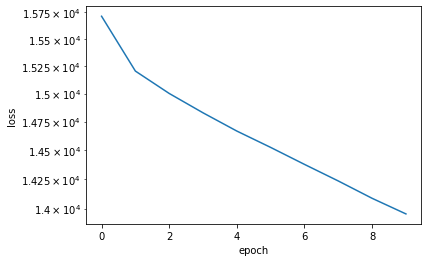

In [39]:
# set up the optimizer
optim_ = optim.Adam(params=net.parameters(), lr=0.001)

n_epochs = 10
for epoch in range(n_epochs):
    running_loss = 0.0
    for data in dataloader:
        X_, y_ = data

        # reset the gradients
        optim_.zero_grad()

        # forward pass
        output =  net(X_, y_)

        # compute the loss
        loss = criterion(output, y_)

        # clip the gradients
        nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

        # backward pass
        loss.backward()

        # update the weights
        optim_.step()
        running_loss += loss.item()

    print(f'epoch: {epoch}, loss: {running_loss}')

    losses.append(running_loss)

# plot the losses
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
short_name = 'tiny'
plt.savefig(f'../figures/{short_name}_transformer_{d_model}_{nhead}_{num_encoder_layers}_{num_decoder_layers}_{dim_feedforward}.png', dpi=300)

In [40]:
def plot_trajectory(p_tango, p_pred, q_tango, q_pred):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(2, 12, wspace=0.7, hspace=0.2)
    ax_p = [fig.add_subplot(gs[0, :4]), fig.add_subplot(gs[0, 4:8]), fig.add_subplot(gs[0, 8:])]
    ax_q = [fig.add_subplot(gs[1, :3]), fig.add_subplot(gs[1, 3:6]), fig.add_subplot(gs[1, 6:9]), fig.add_subplot(gs[1, 9:])]

    # plot positions
    for i in range(3):
        ax_p[i].plot(p_tango[:,i], label='tango')
        ax_p[i].plot(p_pred[:,i], label='pred')
        ax_p[i].set_title('position {}'.format(i))
        ax_p[i].legend()

    # plot quaternions
    for i in range(4):
        ax_q[i].plot(q_tango[:,i], label='tango')
        ax_q[i].plot(q_pred[:,i], label='pred')
        ax_q[i].set_title('quaternion {}'.format(i))
        ax_q[i].legend()

    return fig

# predict
N = 5000
with torch.no_grad():
    # y_pred = net(X, y) dont use the whole dataset
    y_pred = net(X[:N], y[:N])

# plot
fig = plot_trajectory(p_tango[:N], y_pred[:N,9:12], q_tango[:N], y_pred[:N,12:])


In [ ]:
# considering which free parameters there are
# 1. the number of layers in the encoder and decoder
# 2. the number of heads
# 3. the dimension of the model (but this is kinda fixed)
# 4. the dimension of the feedforward network
# 5. the dropout rate
# 6. the activation function
# 7. the custom encoder and decoder
# 8. the learning rate
# 9. the batch size